# Fitting Resnet32 and Resnet 50 on DHCD (Devanagari) Dataset

Training Resnet32 and Resnet50 models using the fastai library on the [DHCD (Devanagari) Dataset](https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset) 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Importing fastai library

In [20]:
from fastai import *
from fastai.vision import *

### Creating ImageDataBunch from the dataset

In [23]:
path = Path('/home/jupyter/devanagari-classifier/Dataset/')
path.ls()

[PosixPath('/home/jupyter/devanagari-classifier/Dataset/Test'),
 PosixPath('/home/jupyter/devanagari-classifier/Dataset/Train'),
 PosixPath('/home/jupyter/devanagari-classifier/Dataset/models'),
 PosixPath('/home/jupyter/devanagari-classifier/Dataset/.DS_Store')]

### Verifying the number of files in Train, Test and Validation sets

The dataset has no Validation set. So, I attempt to create a validation dataset.

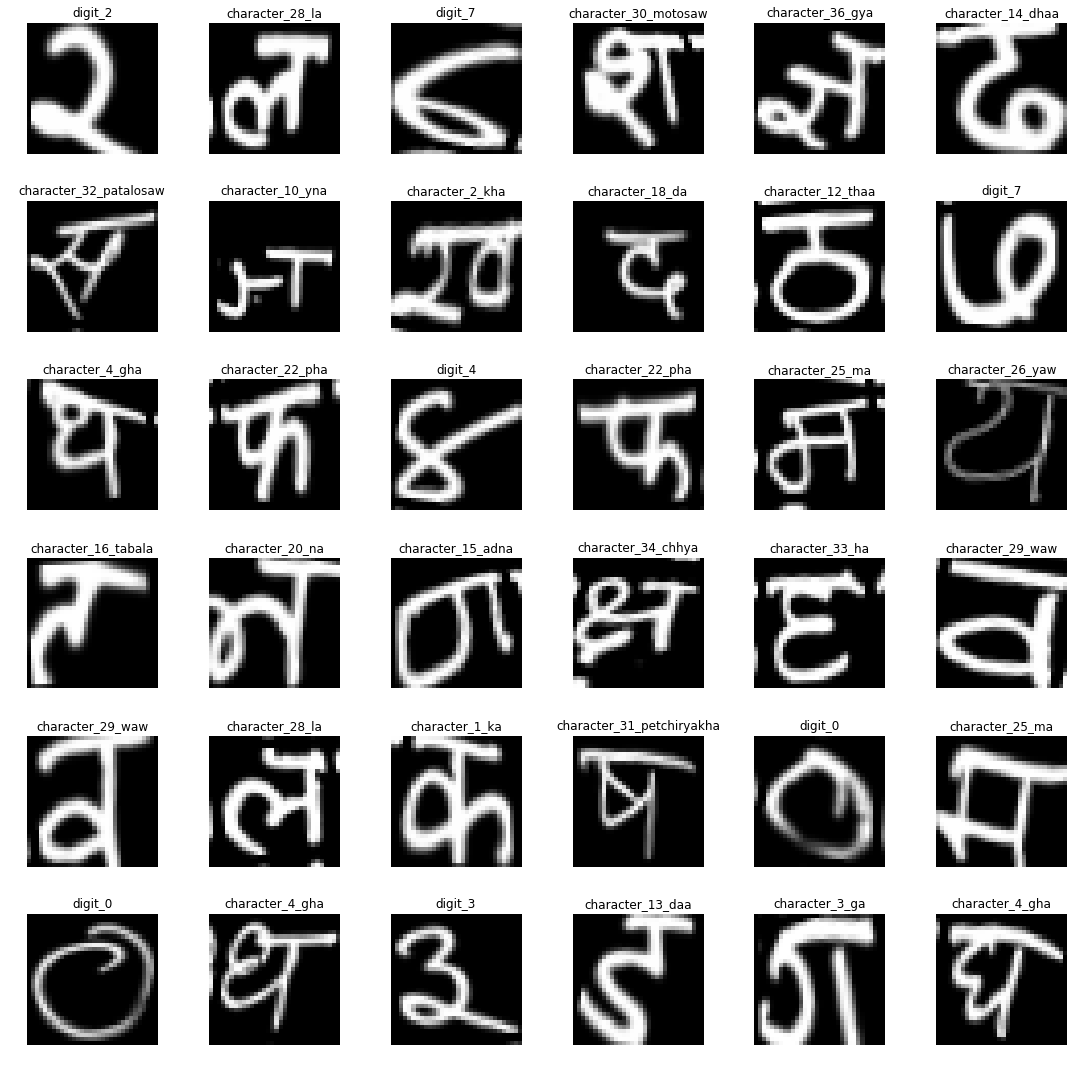

In [24]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path=path, train='Train', test='Test', valid_pct=0.2, ds_tfms=tfms)
data.show_batch(rows=6, figsize=(15,15))

In [25]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (73600 items)
[Category character_27_ra, Category character_27_ra, Category character_27_ra, Category character_27_ra, Category character_27_ra]...
Path: /home/jupyter/devanagari-classifier/Dataset
x: ImageItemList (73600 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: /home/jupyter/devanagari-classifier/Dataset;

Valid: LabelList
y: CategoryList (18400 items)
[Category character_24_bha, Category character_13_daa, Category character_12_thaa, Category character_20_na, Category character_25_ma]...
Path: /home/jupyter/devanagari-classifier/Dataset
x: ImageItemList (18400 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: /home/jupyter/devanagari-classifier/Dataset;

Test: LabelList
y: EmptyLabelList (13800 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (13800 item

# Training Resnet34

In [26]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [27]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,1.989177,1.476193,0.416250
2,0.973958,0.591563,0.178750
3,0.624602,0.330067,0.098587
4,0.486433,0.247491,0.076902
5,0.422208,0.198986,0.060924
6,0.403650,0.193766,0.059402


In [28]:
learn.save('stage-1-34')

### Unfreezing and fine-tuning

In [29]:
doc(learn.unfreeze)

unfreeze [source] unfreeze () 
 
 Unfreeze entire model. 
 Show in docs

In [30]:
learn.load('stage-1-34');

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


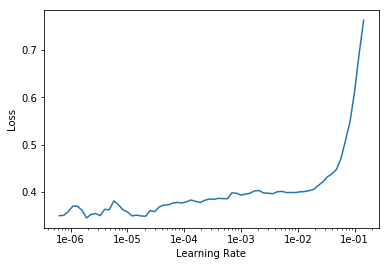

In [32]:
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.277522,0.132300,0.039565
2,0.096255,0.044500,0.013207


In [34]:
learn.load('stage-1-34');

In [35]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.304795,0.150484,0.046413
2,0.247846,0.096051,0.029022
3,0.164805,0.072248,0.021957
4,0.105046,0.043199,0.013750
5,0.051656,0.029254,0.008696
6,0.044003,0.025805,0.007935


In [36]:
learn.save('stage-2-34')

In [37]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.038929,0.022618,0.006902


In [38]:
learn.save('stage-3-34')

In [39]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.047755,0.024341,0.007446


The model is starting to overfit here, so let's load up the previous saved model. 

In [40]:
learn.load('stage-3-34');

### Results

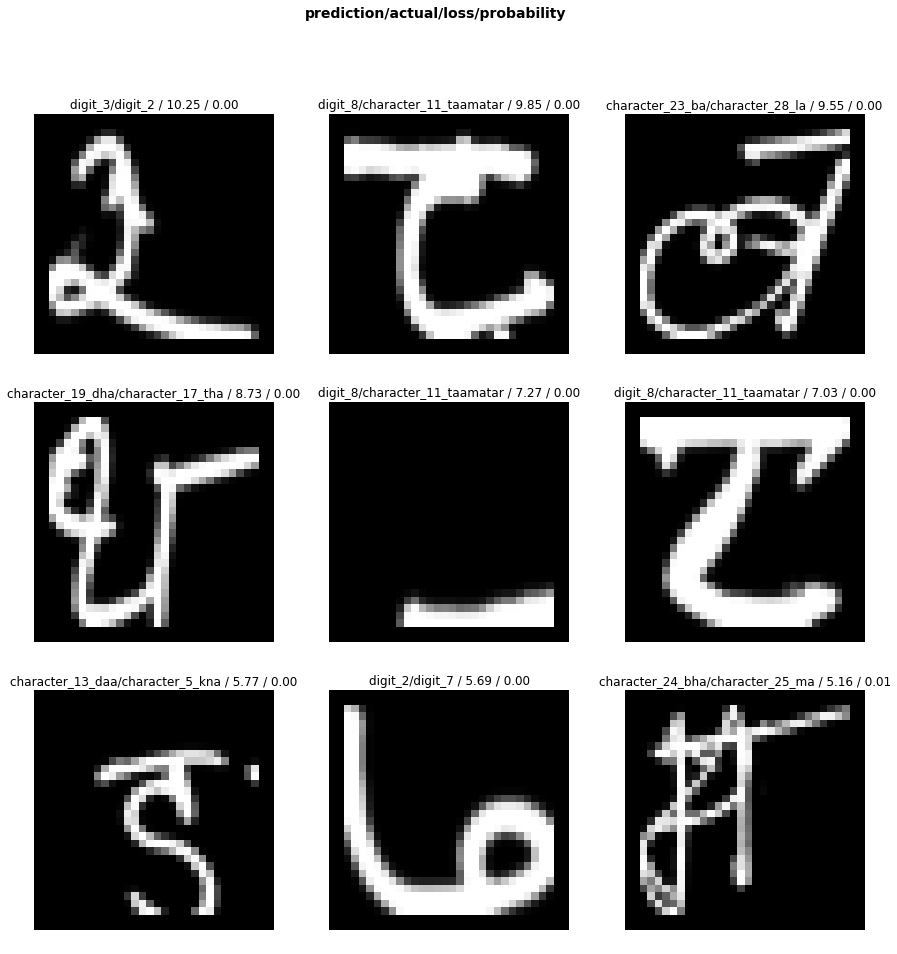

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

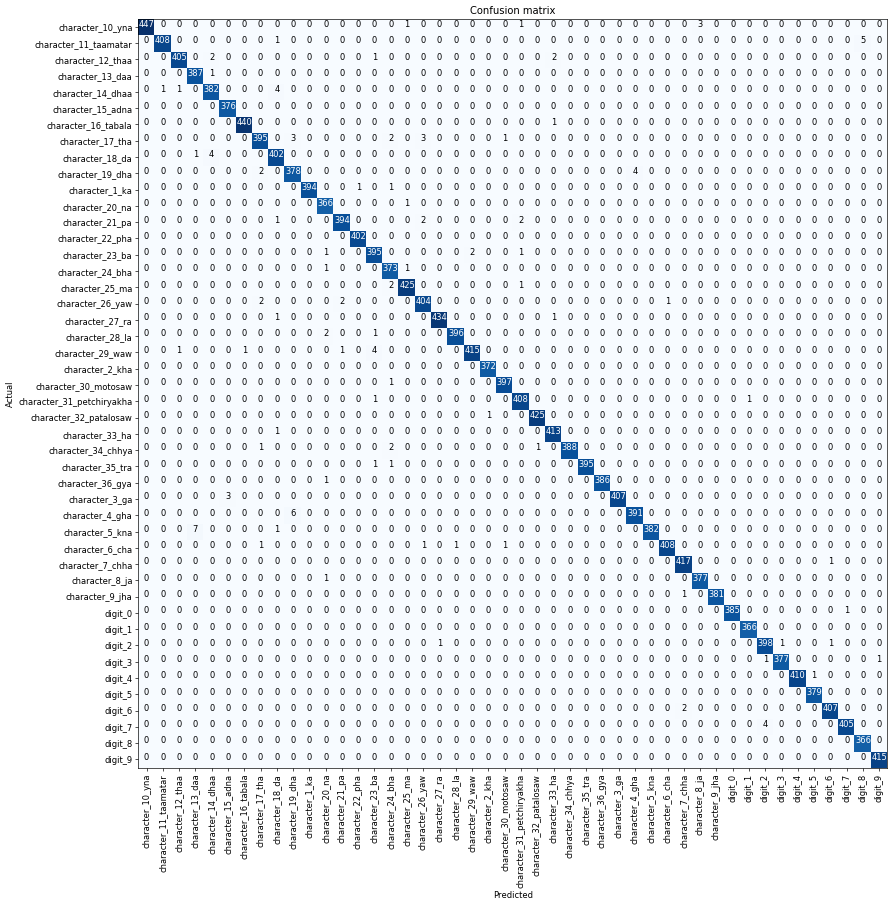

In [42]:
interp.plot_confusion_matrix(figsize=(15,15),dpi=60)

My native language uses the Devanagari script, and I was confused by some of those. I think it's safe to say that the model has done a good job. The final accuracy is 99.35%. 

Now, let's try replicating this with Resnet50.

# Training Resnet50

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


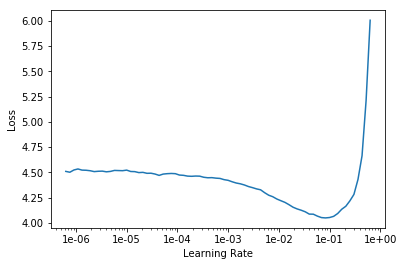

In [44]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,1.906271,1.460916,0.411848
2,0.838391,0.467351,0.140054
3,0.437851,0.217103,0.066848
4,0.315961,0.143501,0.044565
5,0.246973,0.117305,0.036685
6,0.218450,0.107291,0.032717


In [46]:
learn.save('stage-1-res50')

### Unfreezing and fine-tuning

In [47]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-1))

epoch,train_loss,valid_loss,error_rate
1,3.589613,1650.598511,0.174946
2,2.646188,67.996429,0.045000
3,0.602816,20089.972656,0.051250
4,0.117592,5069.083496,0.030815


Okay, that messed things up, alright. I am going to stick with the standard fit_one_cycle() for this one.

In [48]:
learn.load('stage-1-res50');
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.253261,0.119734,0.035272
2,0.107839,0.059829,0.016522
3,0.062394,0.027307,0.008533
4,0.028083,0.018615,0.005435


Thats an accuracy of 99.5% in ten cycles. Much better than resnet34.

In [49]:
learn.save('stage-2-res50')

In [50]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.038428,0.025179,0.007120


That made things worse.

In [52]:
learn.load('stage-2-res50');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.096717,0.038491,0.008859
2,0.028612,0.021512,0.005109


In [53]:
learn.save('stage-3-res50')

In [54]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.057253,0.051833,0.010707
2,0.028365,0.058743,0.005543


The validation loss has gone up here. Let's stick with stage 3. 

In [55]:
learn.load('stage-3-res50');

### Results

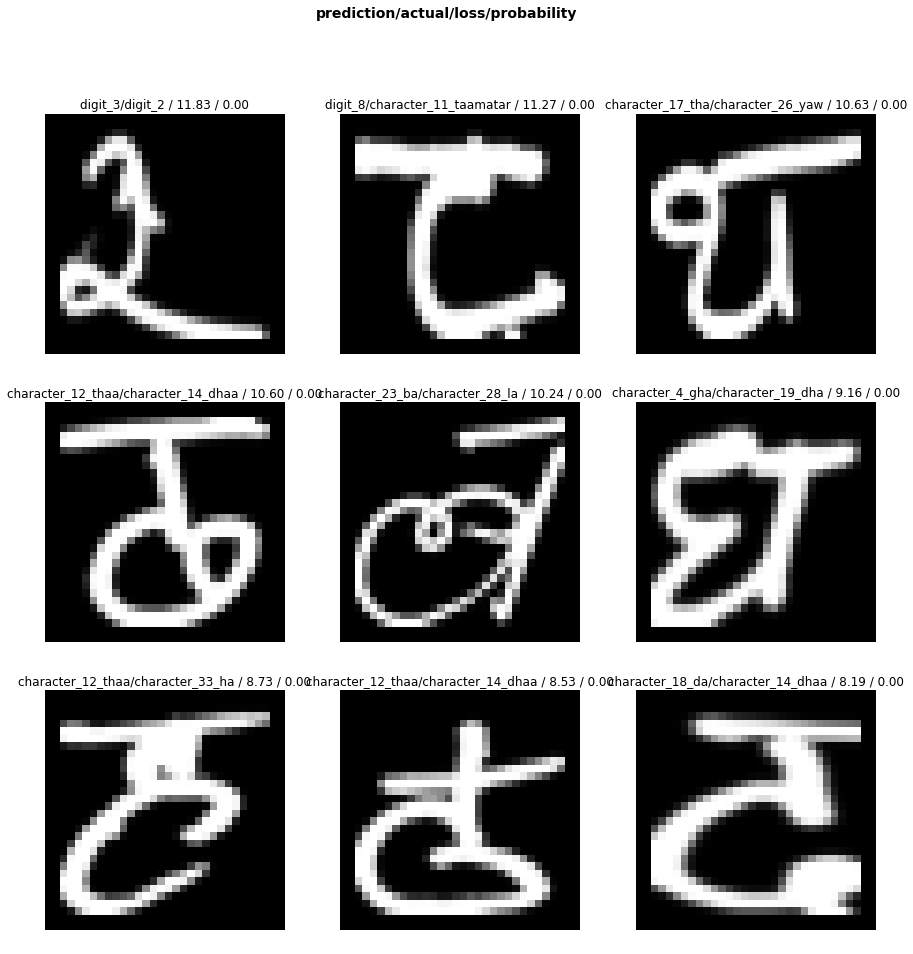

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

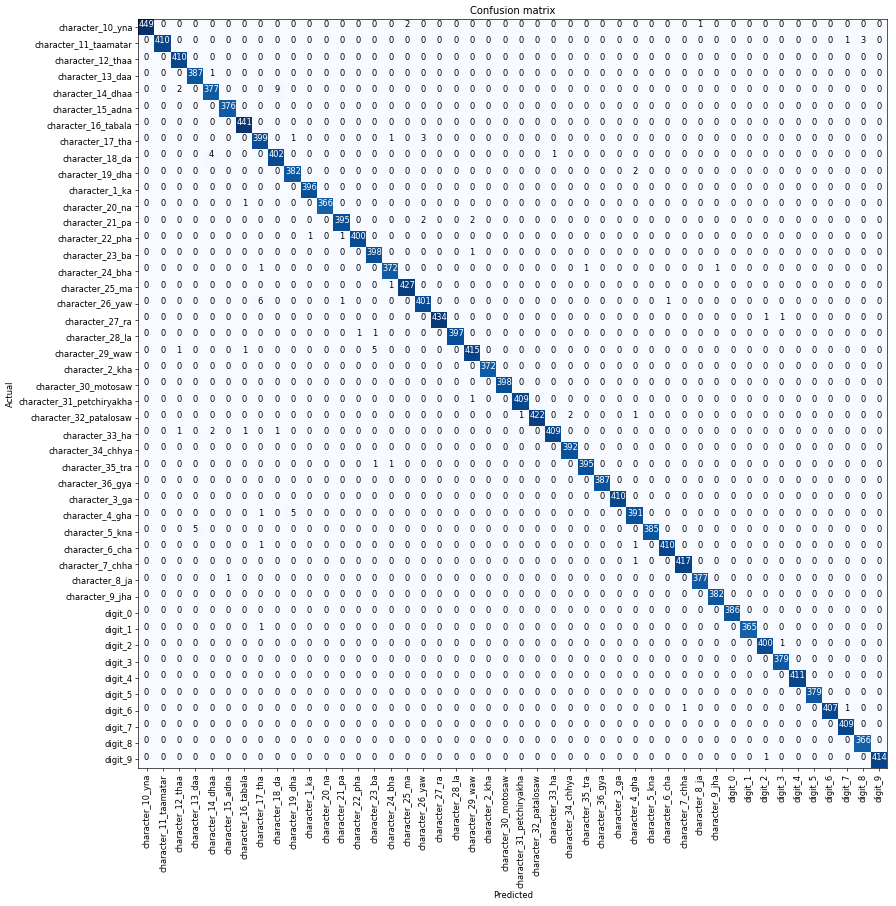

In [57]:
interp.plot_confusion_matrix(figsize=(15,15),dpi=60)

# Conclusion

Resnet34 took a total of 11:41 to create a classifier with an accuracy of 99.26%. This required unfreezing to generate better results. Resnet50, however, took 11:30 to create a classifier with an accuracy of 99.5%, without unfreezing the layers. 